In [1]:
import crocoddyl
import pinocchio
from IPython.display import HTML
import mim_solvers
import numpy as np
import random
from matplotlib import animation
from matplotlib import pyplot as plt
from PointMass_utils import *
from PointMass_model import DifferentialActionModelPointMass

In [2]:
nx = 4
nu = 2
T = 30
start_point = np.array([0, 0, 0, 0])
target_low = np.array([10, 0, 0, 0])
target_high = np.array([10, 10, 0, 0])
obs0 = Obstacle(5, 5, 2, 'Obs0')
obs1 = Obstacle(3.5, 3.5, 1, 'Obs1')
obs2 = Obstacle(6.5, 6.5, 1, 'Obs2')
obs3 = Obstacle(6.5, 3.5, 1, 'Obs3')
obs_set = [obs1, obs2, obs3]
translation_cost = XReg(nx, target_high, 'trans_high')
xreg = XReg(nx, start_point, 'XReg')
ureg = UReg(nu, None, 'UReg')

cost_set = Costs()
cost_set.add_cost(translation_cost)
cost_set.add_cost(xreg)
cost_set.add_cost(ureg)
# cost_set.add_cost(obs0)
cost_set.add_cost(obs1)
cost_set.add_cost(obs2)
cost_set.add_cost(obs3)

nr = cost_set.nr

In [3]:
# Desired Running and Terminal Model
w_run = np.array([10, .1, .1, 500, 350, 100])
w_term = np.array([1000, .1, .1, 100, 150, 200])
w_des = (np.hstack([w_run, w_term])/(np.max(np.hstack([w_run, w_term])))).copy()
# w_des = np.hstack([w_run, w_term])
w_run = w_des[:nr]; w_term = w_des[nr:]
PM_DAM_running = DifferentialActionModelPointMass(cost_set, w_run)
PM_DAM_terminal = DifferentialActionModelPointMass(cost_set, w_term)
pmDataRunning = PM_DAM_running.createData()
pmDataTerminal = PM_DAM_terminal.createData()
PM_ND_R = crocoddyl.DifferentialActionModelNumDiff(PM_DAM_running, False)
PM_ND_T = crocoddyl.DifferentialActionModelNumDiff(PM_DAM_terminal, False)
timeStep = 5e-2
PM_IAM = crocoddyl.IntegratedActionModelEuler(PM_ND_R, timeStep)
PM_IAM_T = crocoddyl.IntegratedActionModelEuler(PM_ND_T, 0.0)
x0 = np.array([0.0, 0.0, 0.0, 0.0])
u0 = np.array([0.0, 0.0])
problem = crocoddyl.ShootingProblem(x0, [PM_IAM] * T, PM_IAM_T)
# Creating the SQP solver
sqp_opt = mim_solvers.SolverSQP(problem)
sqp_opt.setCallbacks([crocoddyl.CallbackVerbose()])
sqp_opt.with_callbacks=True
sqp_opt.termination_tolerance = 1e-5
xs_init = [x0 for i in range(T+1)]
us_init = [u0 for i in range(T)]

# Solving this problem
done = sqp_opt.solve(xs_init, us_init, 500)
xs_optimal = np.stack(sqp_opt.xs.tolist().copy())
us_optimal = np.stack(sqp_opt.us.tolist().copy())
print(done)

iter     merit         cost         grad      step    ||gaps||        KKT
   1  1.01500e+02  1.01500e+02  4.84001e+01  1.0000  0.00000e+00  9.93890e+00
   2  1.55565e+00  1.55565e+00  8.90598e-02  1.0000  1.59872e-14  1.54531e-02
   3  1.55462e+00  1.55462e+00  5.76705e-02  1.0000  1.02144e-10  5.67325e-03
   4  1.55423e+00  1.55423e+00  4.48540e-02  1.0000  5.57210e-11  2.48182e-03
   5  1.55400e+00  1.55400e+00  3.82850e-02  1.0000  6.68798e-11  1.10428e-03
   6  1.55382e+00  1.55382e+00  3.46879e-02  1.0000  6.64940e-11  5.85425e-04
   7  1.55366e+00  1.55366e+00  3.24589e-02  1.0000  4.70294e-11  5.44206e-04
   8  1.55352e+00  1.55352e+00  3.09644e-02  1.0000  6.13443e-11  6.80731e-04
   9  1.55339e+00  1.55339e+00  2.97902e-02  1.0000  5.19978e-11  7.93115e-04
  10  1.55326e+00  1.55326e+00  2.88142e-02  1.0000  4.96135e-11  8.65032e-04
iter     merit         cost         grad      step    ||gaps||        KKT
  11  1.55314e+00  1.55314e+00  2.79745e-02  1.0000  5.42219e-11  9.1969

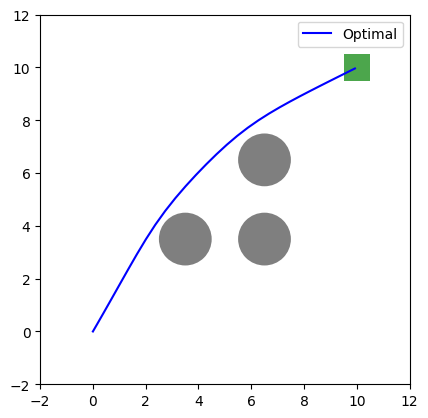

In [4]:
# HTML(animatePointMass(xs_optimal, obs_set, target_high).to_jshtml())
plot_1_traj(xs_optimal, obs_set, target_high, label='Optimal', linemap = 'b')

In [102]:
# Random Generation of bad weight vectors
w_bads = []
num_bad = 3
K = 3
for i in range(num_bad):
    bad_weight_count = range(nr,len(w_des))
    bads = random.choice(bad_weight_count)
    w_0 = random.choices(range(len(w_des)), np.ones_like(w_des), k=bads)
    w_dummy = w_des.copy()
    # w_dummy[w_0] = np.random.uniform(0.0, 1.0, len(w_0))
    w_dummy[w_0] = 0.0
    w_dummy /= np.max(w_dummy)
    w_bads.append(w_dummy)

In [ ]:
# # Non-Optimal Demo Collection
# xs_non_optimal_set = []
# us_non_optimal_set = []
# for w_i, w_bad in enumerate(w_bads):
#     # w_bad /= np.max(w_bad)
#     w_run = w_bad[:nr]
#     w_term = w_bad[nr:]
#     PM_DAM_running = DifferentialActionModelPointMass(cost_set, w_run)
#     PM_DAM_terminal = DifferentialActionModelPointMass(cost_set, w_term)
#     pmDataRunning = PM_DAM_running.createData()
#     pmDataTerminal = PM_DAM_terminal.createData()
#     PM_ND_R = crocoddyl.DifferentialActionModelNumDiff(PM_DAM_running, False)
#     PM_ND_T = crocoddyl.DifferentialActionModelNumDiff(PM_DAM_terminal, False)
#     timeStep = 5e-2
#     PM_IAM = crocoddyl.IntegratedActionModelEuler(PM_ND_R, timeStep)
#     PM_IAM_T = crocoddyl.IntegratedActionModelEuler(PM_ND_T, 0.0)
#     x0 = np.array([0.0, 0.0, 0.0, 0.0])
#     u0 = np.array([0.0, 0.0])
#     problem = crocoddyl.ShootingProblem(x0, [PM_IAM] * T, PM_IAM_T)
#     # Creating the SQP solver
#     sqp_non_opt = mim_solvers.SolverSQP(problem)
#     sqp_non_opt.setCallbacks([crocoddyl.CallbackVerbose()])
#     sqp_non_opt.with_callbacks=False
#     sqp_non_opt.termination_tolerance = 1e-5
#     xs_init = [x0 for i in range(T+1)]
#     us_init = [u0 for i in range(T)]
    
#     # Solving this problem
#     done = sqp_non_opt.solve(xs_init, us_init, 500)
#     xs_non_optimal = np.stack(sqp_non_opt.xs.tolist().copy())
#     us_non_optimal = np.stack(sqp_non_opt.us.tolist().copy())
#     xs_non_optimal_set.append(xs_non_optimal)
#     us_non_optimal_set.append(us_non_optimal)
#     for k in range(K):
#         Us = us_non_optimal.copy()+np.random.normal(0.01,np.stack(us_non_optimal.tolist()).shape)
#         # Xs = xs_non_optimal.copy()+np.random.normal(0,0.15,np.stack(xs_non_optimal.tolist()).shape)
#         us_non_optimal_set.append(Us)
#         xs_non_optimal_set.append(np.stack(problem.rollout([Us[i] for i in range(T)])))
#     print('{}\'th non-optimal collected: {}'.format(w_i+1, done))


In [139]:
# Non-Optimal Demo Collection from Optimal
K = 15
xs_non_optimal_set = []
us_non_optimal_set = []
for k in range(K):
    Us = us_optimal.copy()+np.random.normal(0.005,np.stack(us_optimal.tolist()).shape)
    # Xs = xs_non_optimal.copy()+np.random.normal(0,0.15,np.stack(xs_non_optimal.tolist()).shape)
    us_non_optimal_set.append(Us)
    xs_non_optimal_set.append(np.stack(problem.rollout([Us[i] for i in range(T)])))
print('{}\'th non-optimal collected: {}'.format(k+1, done))


15'th non-optimal collected: True


In [140]:
c = 0
for i, (X, U) in enumerate(zip(xs_non_optimal_set, us_non_optimal_set)):
    print(np.exp(-cost_set.traj_cost(X, U, w_des[:nr], w_des[nr:], timeStep)))
    c+= np.exp(-cost_set.traj_cost(X, U, w_des[:nr], w_des[nr:], timeStep))

print()
print(c)

1.4772008216012287e-10
1.8192754780048077e-23
0.002496982766763135
1.9615361590712086e-10
4.980430958524605e-30
3.2710509977178735e-17
4.8187605156601715e-37
4.892013193479749e-16
8.191420121363796e-05
3.6359378733413263e-47
8.630515967720914e-23
0.00019655619919670584
0.0003075753916632346
2.4459288284370004e-42
2.706982102985908e-24

0.003083028902710933


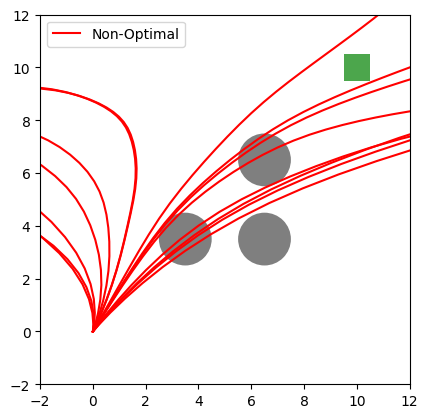

In [141]:
# HTML(animatePointMass(xs_non_optimal, obs_set, target_high).to_jshtml())
plot_1_set(xs_non_optimal_set, obs_set, target_high, label='Non-Optimal', linemap_traj = 'r', linemap_set = 'r')

In [142]:
# IRL Algorithm
from scipy.optimize import minimize
from scipy.optimize import Bounds

def fcn_w(x, cost_set, xs_optimal, us_optimal, xs_non_optimal_set, us_non_optimal_set, dt, Lambda = 0.001):
    nr = cost_set.nr
    output = 0
    num = np.nextafter(0,1)
    den = np.nextafter(0,1)
    num += np.exp(-cost_set.traj_cost(xs_optimal, us_optimal, x[:nr], x[nr:], dt))
    den += num
    for Xs, Us in zip(xs_non_optimal_set, us_non_optimal_set):
        # o_i = np.exp(-np.linalg.norm(xs_optimal-Xs)) # Optimality factor
        o_i = 1
        den += o_i*np.exp(-cost_set.traj_cost(Xs, Us, x[:nr], x[nr:], dt))
    output -= np.log(num/den)
    output += Lambda*np.linalg.norm(x)
    return output

In [178]:
dt = timeStep
Lambda = 0.01
lb = 0.0; ub = np.inf
bnds = Bounds(lb, ub)
options = {'maxiter': 100, 'iprint': 1,'ftol': 1e-10 ,'gtol' : 1e-10}
tol = 1e-10
# x0 = random.choice(w_bads)
# x0 = w_des
x0 = np.random.uniform(0.0, 1.0, len(w_des))
res_1D = minimize(fcn_w, 
               x0, 
               args=(cost_set, xs_optimal, us_optimal, xs_non_optimal_set, us_non_optimal_set, dt, Lambda), 
               bounds=bnds, 
               method='L-BFGS-B', 
               tol = tol,
               options=options)

print(res_1D)
w_irl = res_1D.x

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.84352D-02    |proj g|=  5.55482D-02

At iterate    1    f=  2.35404D-02    |proj g|=  2.66263D-02

At iterate    2    f=  2.10901D-02    |proj g|=  1.22798D-02

At iterate    3    f=  1.95418D-02    |proj g|=  6.24989D-03

At iterate    4    f=  1.79817D-02    |proj g|=  4.69738D-03

At iterate    5    f=  1.54393D-02    |proj g|=  4.08511D-03

At iterate    6    f=  1.27257D-02    |proj g|=  6.34695D-03

At iterate    7    f=  1.13571D-02    |proj g|=  5.97897D-03

At iterate    8    f=  9.96762D-03    |proj g|=  2.48102D-03

At iterate    9    f=  9.95394D-03    |proj g|=  2.12279D-03

At iterate   10    f=  9.88582D-03    |proj g|=  4.13930D-04

At iterate   11    f=  9.88350D-03    |proj g|=  1.30622D-04

At iterate   12    f=  9.88301D-03    |proj g|=  1.20000D-04

At iterate   13    f=  9.8

In [179]:
# w_irl /= np.max(w_irl)
for i, cost in enumerate(cost_set.costs):
    print(cost.name, ':')
    print('Running || ', 'Desired: ', w_des[:nr][i], 'IRL: ', w_irl[:nr][i])
    print('Terminal || ', 'Desired: ', w_des[nr:][i], 'IRL: ', w_irl[nr:][i])
    print('')

trans_high :
Running ||  Desired:  0.01 IRL:  0.29238795401839485
Terminal ||  Desired:  1.0 IRL:  0.6137305534877993

XReg :
Running ||  Desired:  0.0001 IRL:  0.34496658992798884
Terminal ||  Desired:  0.0001 IRL:  0.42258528197434814

UReg :
Running ||  Desired:  0.0001 IRL:  0.0
Terminal ||  Desired:  0.0001 IRL:  6.419114326314704e-07

Obs1 :
Running ||  Desired:  0.5 IRL:  0.0
Terminal ||  Desired:  0.1 IRL:  0.0

Obs2 :
Running ||  Desired:  0.35 IRL:  0.0
Terminal ||  Desired:  0.15 IRL:  0.0

Obs3 :
Running ||  Desired:  0.1 IRL:  0.0
Terminal ||  Desired:  0.2 IRL:  0.0



In [180]:
print('Desired: ')
print('Running ==>    ', w_des[:nr])
print('Terminal ==>   ', w_des[nr:])
print('IRL: ')
print('Running ==>    ', w_irl[:nr])
print('Terminal ==>   ', w_irl[nr:])

Desired: 
Running ==>     [1.0e-02 1.0e-04 1.0e-04 5.0e-01 3.5e-01 1.0e-01]
Terminal ==>    [1.0e+00 1.0e-04 1.0e-04 1.0e-01 1.5e-01 2.0e-01]
IRL: 
Running ==>     [0.29238795 0.34496659 0.         0.         0.         0.        ]
Terminal ==>    [6.13730553e-01 4.22585282e-01 6.41911433e-07 0.00000000e+00
 0.00000000e+00 0.00000000e+00]


In [181]:
print('Desired Trajectory Cost: ', cost_set.traj_cost(xs_optimal, us_optimal, w_des[:nr], w_des[nr:], timeStep), ' || with IRL Weight:  ', cost_set.traj_cost(xs_optimal, us_optimal, w_irl[:nr], w_irl[nr:], timeStep))
# print('Bad Trajectory Cost:     ', cost_set.traj_cost(xs_non_optimal, us_non_optimal, x0[:nr], x0[nr:], timeStep), ' || with IRL Weight:  ', cost_set.traj_cost(xs_non_optimal, us_non_optimal, w_irl[:nr], w_irl[nr:], timeStep))

Desired Trajectory Cost:  0.4891303384091839  || with IRL Weight:   18.162252913723812


In [182]:
# Test IRL 1D Output
print('Desired Fcn:    ', fcn_w(w_des, cost_set, xs_optimal, us_optimal, xs_non_optimal_set, us_non_optimal_set, dt, Lambda))
print('IRL Fcn:     ', fcn_w(w_irl, cost_set, xs_optimal, us_optimal, xs_non_optimal_set, us_non_optimal_set, dt, Lambda))
# print('Bad Fcn:        ', fcn_w(x0, cost_set, xs_optimal, us_optimal, xs_non_optimal_set, us_non_optimal_set, dt, Lambda))

Desired Fcn:     0.01707825748991086
IRL Fcn:      0.009881930887518925


In [183]:
# Run again with bad weights (zero for obstacles)
w_run = w_irl[:nr]
w_term = w_irl[nr:]
PM_DAM_running = DifferentialActionModelPointMass(cost_set, w_run)
PM_DAM_terminal = DifferentialActionModelPointMass(cost_set, w_term)
pmDataRunning = PM_DAM_running.createData()
pmDataTerminal = PM_DAM_terminal.createData()
PM_ND_R = crocoddyl.DifferentialActionModelNumDiff(PM_DAM_running, False)
PM_ND_T = crocoddyl.DifferentialActionModelNumDiff(PM_DAM_terminal, False)
timeStep = 5e-2
PM_IAM = crocoddyl.IntegratedActionModelEuler(PM_ND_R, timeStep)
PM_IAM_T = crocoddyl.IntegratedActionModelEuler(PM_ND_T, 0.0)
x0 = np.array([0.0, 0.0, 0.0, 0.0])
u0 = np.array([0.0, 0.0])
problem = crocoddyl.ShootingProblem(x0, [PM_IAM] * T, PM_IAM_T)
# Creating the SQP solver
sqp = mim_solvers.SolverSQP(problem)
sqp.setCallbacks([crocoddyl.CallbackVerbose()])
sqp.with_callbacks=True
sqp.termination_tolerance = 1e-5
# xs_init = [x0 for i in range(T+1)]
# us_init = [u0 for i in range(T)]
xs_init = [xs_optimal[i] for i in range(T+1)]
us_init = [us_optimal[i] for i in range(T)]

# Solving this problem
done = sqp.solve(xs_init, us_init, 500)
xs_output = np.stack(sqp.xs.tolist().copy())
us_output = np.stack(sqp.us.tolist().copy())

iter     merit         cost         grad      step    ||gaps||        KKT
   1  1.25126e+02  1.25126e+02  3.40422e+01  1.0000  3.57920e-10  5.60894e+00
 END  6.59191e+01  6.59191e+01  2.29900e-04   ----   4.93916e-08  1.49487e-06


15.530874308761566


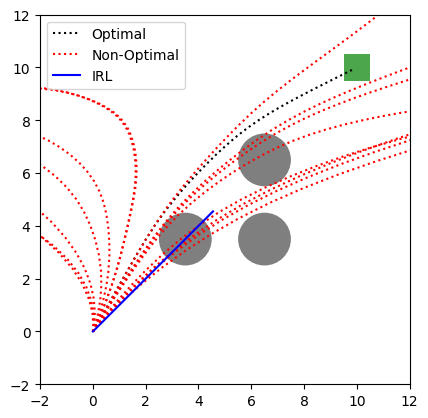

In [184]:
print(cost_set.traj_cost(xs_output, us_output, w_irl[:nr], w_irl[nr:], dt))
plot_results(xs_optimal, xs_non_optimal_set, xs_output, obs_set, target_high)